In [10]:
import shutil
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

import os

import numpy as np
import torch

import stCMGAE
from pathlib import Path
import scanpy as sc
import pandas as pd
from sklearn import metrics
stCMGAE.utils.fix_seed(2024)

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
tissue_name = "151676"
n_clusters = 5 if tissue_name in ['151669', '151670', '151671', '151672'] else 7
# path
data_root = Path("./data/DLPFC/")
count_file = tissue_name + "_filtered_feature_bc_matrix.h5"
adata = sc.read_visium(data_root / tissue_name, count_file=count_file)
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [12]:
args = stCMGAE.utils.build_args()
args.hidden_dim, args.latent_dim = 512, 256
args.att_dropout_rate = 0.2
args.gradient_clipping = 5
args.max_epoch = 300
args.feat_mask_rate = 0.8
args.top_genes = 2000
args.k_cutoff = 12
args.lam = 0.5
args.momentum = 0.94

In [13]:
net = stCMGAE.stCMGAE(adata,
                      tissue_name=tissue_name,
                      num_clusters=n_clusters,
                      genes_model='pca',
                      top_genes=args.top_genes,
                      rad_cutoff=200,
                      k_cutoff=args.k_cutoff,
                      graph_model='KNN',
                      device=device,
                      learning_rate=args.learning_rate,
                      weight_decay=args.weight_decay,
                      max_epoch=args.max_epoch,
                      gradient_clipping=args.gradient_clipping,
                      feat_mask_rate=args.feat_mask_rate,
                      hidden_dim=args.hidden_dim,
                      latent_dim=args.latent_dim,
                      bn=args.bn,
                      att_dropout_rate=args.att_dropout_rate,
                      use_token=args.use_token,
                      alpha=args.alpha,
                      random_seed=args.seed,
                      nps=args.nps,
                      momentum=args.momentum,
                      lam=args.lam)

------Calculating spatial graph...
The graph contains 41520 edges, 3460 cells.
12.0000 neighbors per cell on average.
(3460, 200)


In [14]:
net.train()
method = "kmeans"
net.process()
net.clustering(method=method)
adata = net.get_adata()

Dataset_Name:151676, Ep 299: train loss:0.2053: 100%|██████████| 300/300 [00:04<00:00, 74.28it/s]


In [15]:
truth_path = "./data/DLPFC/" + tissue_name + '/' + tissue_name + '_truth.txt'
Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
sub_adata = adata[~pd.isnull(adata.obs['Ground Truth'])]
ari, ami, nmi, cs, fms, vms, hs = stCMGAE.utils.measureClusteringTrueLabel(sub_adata.obs['Ground Truth'], sub_adata.obs[method])

In [16]:
print(f"ARI:{ari}\tNMI:{nmi}")

ARI:0.557115406166099	NMI:0.6844111425459461


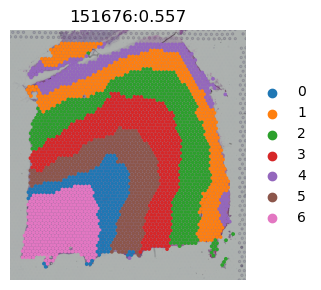

In [17]:
fig, axs = plt.subplots(figsize=(4, 3))
sc.pl.spatial(adata, color=[method], title=tissue_name + ':' + str(round(ari, 3)),ax=axs, show=False, size=1.5)
axs.axis('off')
plt.tight_layout()
plt.savefig(tissue_name + "_stCMGAE_domain.pdf")

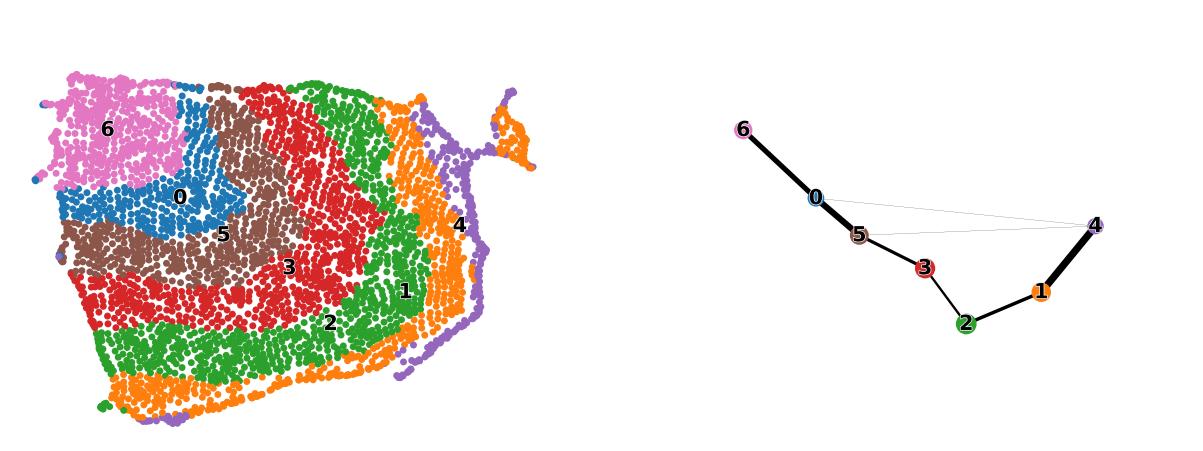

In [18]:
sc.pp.neighbors(adata, n_neighbors=12, n_pcs=30, use_rep='eval_pred')
sc.tl.umap(adata)
sc.tl.paga(adata, groups=method)
sc.pl.paga_compare(adata, legend_fontsize=15, frameon=False, size=100, title=' ', legend_fontoutline=1, show=False)
plt.tight_layout()
plt.savefig(tissue_name + "_stCMGAE_visualization.pdf")

In [19]:
adata.write(tissue_name + "_results.h5ad")